# FRAUD DETECTION IN BANK TRANSACTIONS

This notebook is by Oladipupo Latona

Bank/Credit Card fraud presents a huge problem for financial institutions today and the creation of reliable fraud detection systems is challenging. The aim of this project is to train a fraud detecting machine learning model on a synthetic dataset and to highlight ways to utilize techniques such as oversampling and threshold moving to deal with class imbalance. 

### Dataset Overview

This Synthetic dataset was generated by BankSim. BankSim is an agent-based simulator of bank payments based on a sample of aggregated transactional data provided by a bank in Spain. The main purpose of BankSim is the generation of synthetic data that can be used for fraud detection research.

### Content:

Step: represents the day when the transaction happened. There is a total of 180 steps, so the data runs for six months. This variable was removed from the dataset.


Customer: represents the unique ID of the person who initialized the transaction. It is formed by the letter C, followed by a unique sequence of 10 numbers. There is a total of 4,109 unique customers available in the dataset.


Age: this variable is split in age intervals, starting from 0 to 6 and the letter U which stands for Unknown. Age is Unknown only for transactions that have the gender equal to Enterprise. The coding for the numbers are:


0: less than 18 years old


1: between 19 and 25 years old


2: between 26 and 35 years old


3: between 36 and 45 years old


4: between 46 and 55 years old


5: between 56 and 65 years old


6: older than 65 years old


Gender: this variable is coded as F for Female, M for Male, E for Enterprise and U for Unknown. The Unknown group has around 170 customers aged in groups 1, 2 and 3.


Merchant: this variable represents the unique ID of the party which receives the transaction. Similar to customer ID, the sequence is formed by the letter M, followed by a series of 9 numbers. There is a total of 50 unique merchants in the dataset.


Category: there are 15 unique categories that label the general type of the transaction: transportation, food, health, wellness and beauty, fashion, bars and restaurant, hyper, sports and toys, tech, home, hotel services, other services, contents, travel, leisure.


Amount: represents the value of the transaction. There are only 52 values equal to 0 and no negative values.


Fraud: a flag column coded with 0 if the transaction was clean and with 1 if the transaction was fraudulent.


zipcodeOri and zipMerchant: these two features were removed from the dataset, as they contained a constant value of 28007, which is a postal code in Ansonville, North Carolina, United States.

### Importing Libraries

In [38]:
import pandas as pd # for data manipulation and analysis
import seaborn as sns # for data visualization in seaborn
import matplotlib.pyplot as plt # for plotting
import numpy as np # for working with arrays and carrying out mathematical operations. Pandas is built on Numpy
from numpy import mean # to calculate mean
from plotly.offline import iplot
import plotly.graph_objs as go # to link plotly to pandas
import cufflinks as cf # to link plotly to pandas

cf.go_offline()
cf.set_config_file(offline = True, world_readable = True)

# Scikit-Learn Library
from sklearn.metrics import confusion_matrix # to print confusion matrix
from sklearn import preprocessing # tp transform data
from sklearn.model_selection import StratifiedKFold # to perform startified k-fold
from sklearn.model_selection import train_test_split # to split data into training and testing data
from sklearn.metrics import classification_report # to print classification report
from sklearn.model_selection import GridSearchCV # to search through the best parameter values
from sklearn.preprocessing import StandardScaler # to scale data
from sklearn import metrics

# Imblearn Library 
from imblearn.under_sampling import RandomUnderSampler # to perform undersampling on the data
from imblearn.over_sampling import SMOTE # to oversample the data 


from xgboost import XGBClassifier
from xgboost import Booster
from xgboost import DMatrix
import random

from numpy import argmax # to calculate optimal threshold
from numpy import sqrt 
import pickle
from collections import Counter
import plotly.express as px # for visualization

### Load Dataset

In [4]:
df = pd.read_csv('/Users/Ladi/Desktop/fraud_detection.csv')
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [5]:
df.dtypes #column datatypes

step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object

In [6]:
df.isnull().sum() #check if there are any null values

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

In [7]:
df.describe() #statistical description 

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [8]:
df.shape #dataframe shape

(594643, 10)

### Data Cleaning

There are some columns with quotes so let's remove them

In [9]:
columns_to_edit = [c for c in df.columns if c not in ['step', 'amount', 'fraud']]
columns_to_edit

['customer',
 'age',
 'gender',
 'zipcodeOri',
 'merchant',
 'zipMerchant',
 'category']

In [10]:
df[columns_to_edit] = df[columns_to_edit].applymap(lambda x: x.replace("'", ""))
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


### Dropping columns 'zipcode0ri', 'zipMerchant' and 'step'

In [11]:
df = df.drop(['zipcodeOri','zipMerchant','step'], axis=1) 
df.head()

,customer,age,gender,merchant,category,amount,fraud
0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,C352968107,2,M,M348934600,es_transportation,39.68,0
2,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,C757503768,5,M,M348934600,es_transportation,35.72,0


### Let's remove the 'es_' in front of the category names 

In [12]:
df['category'] = df['category'].map(lambda x: x.lstrip('es_'))
df.head()

,customer,age,gender,merchant,category,amount,fraud
0,C1093826151,4,M,M348934600,transportation,4.55,0
1,C352968107,2,M,M348934600,transportation,39.68,0
2,C2054744914,4,F,M1823072687,transportation,26.89,0
3,C1760612790,3,M,M348934600,transportation,17.25,0
4,C757503768,5,M,M348934600,transportation,35.72,0


In [13]:
df['age'] = df['age'].replace('U',7) # replacing the unknown age group 'U' with the number 7

In [14]:
df['age'].value_counts()

2    187310
3    147131
4    109025
5     62642
1     58131
6     26774
0      2452
7      1178
Name: age, dtype: int64

We can now see that the 'U' has been replaced by the number 7

## Exploratory Data Analysis

In [15]:
df['fraud'].value_counts() # checking the number of fraud and non-fraud cases

0    587443
1      7200
Name: fraud, dtype: int64

### Let's visualize the distribution

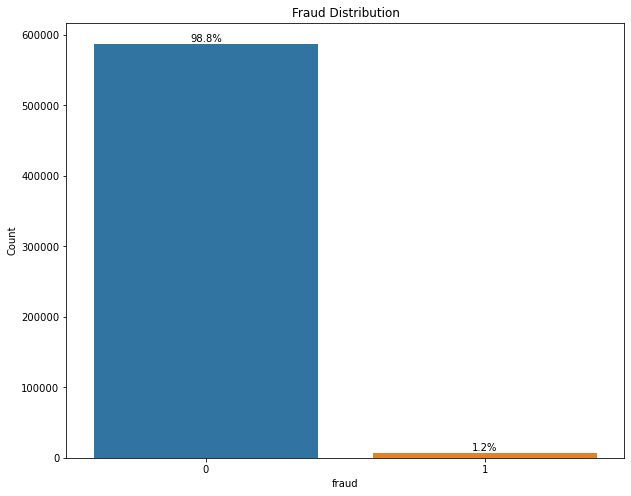

In [16]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="fraud", data=df) 
ax.set(ylabel='Count', title='Fraud Distribution')


# add annotations
for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df.fraud.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()

We can see that the fraud cases are just 1.2% of the total number of cases. This means that the dataset is highly imbalanced and presents a problem. We will deal with this when we're creating a model

### Let's see the age distribution

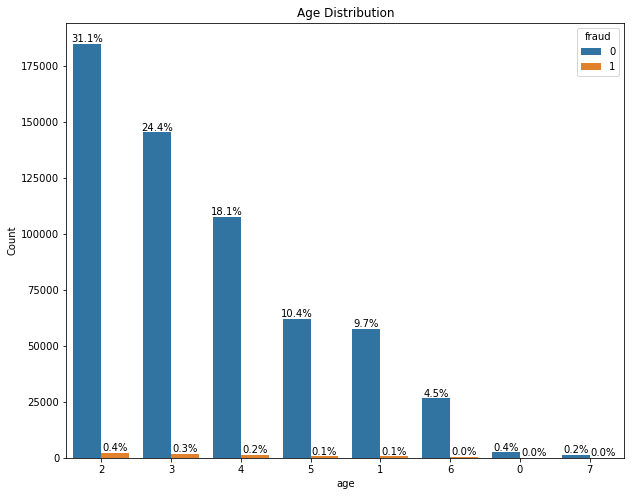

In [17]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="age", hue="fraud", data=df, order = df['age'].value_counts().index)
ax.set(ylabel='Count', title='Age Distribution')


# add annotations
for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df.fraud.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()

We can see that age level 2 has the highest percentage of fraud and non-fraud cases. These are ages between 26 and 35

### Let's see the Gender Distribution

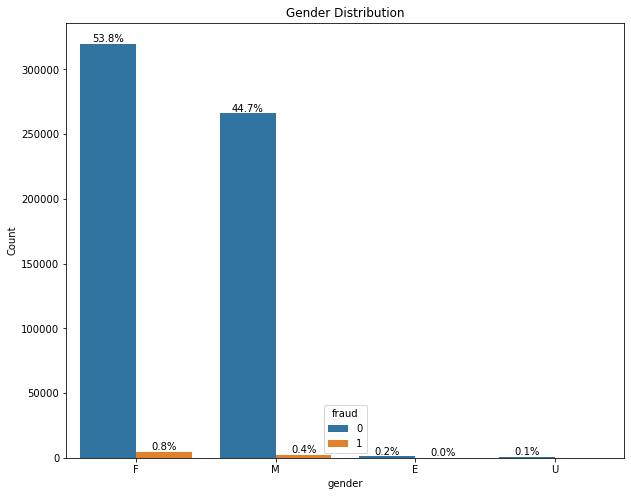

In [18]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="gender", hue="fraud", data=df, order = df['gender'].value_counts().index)
ax.set(ylabel='Count', title='Gender Distribution')


# add annotations
for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df.fraud.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()

We can see that the female gender has a higher percentage of fraud cases (0.8%) than the male gender (0.4%). Gender label 'E' which is for enterprise has 0 fraud cases and label 'U' which stands for unknown has just 0.1% fraud cases

### Let's take a look at the category distribution

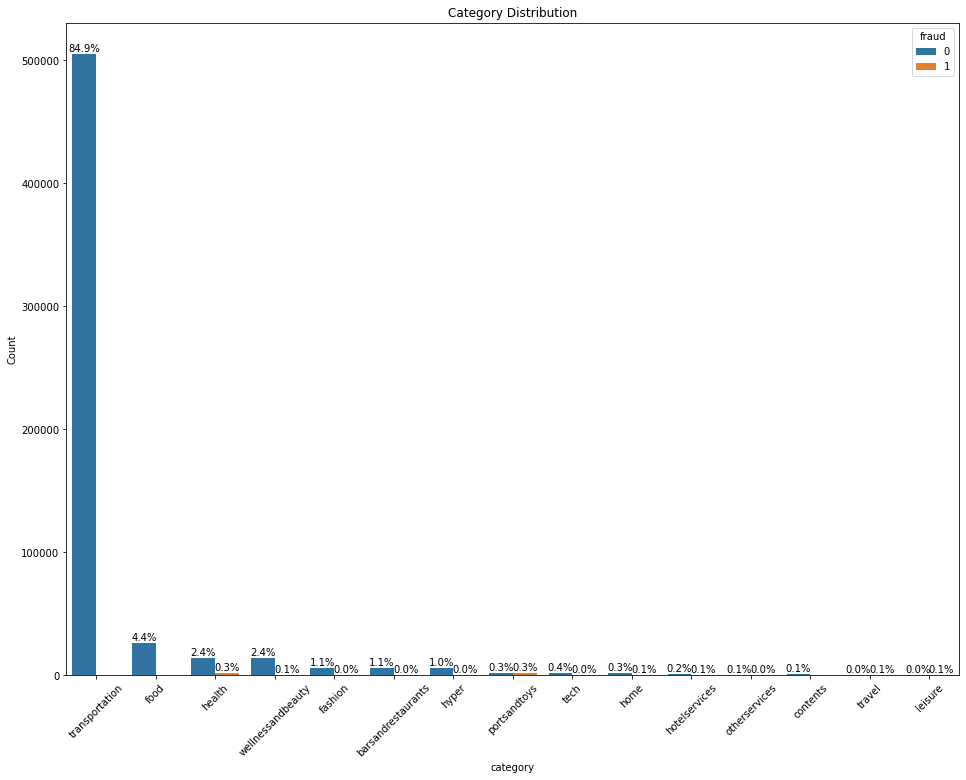

In [19]:
plt.figure(figsize=(16,12))
ax = sns.countplot(x="category", hue='fraud',data=df, order = df['category'].value_counts().index)
ax.set(ylabel='Count', title='Category Distribution')


# add annotations
for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df.fraud.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')
    plt.xticks(rotation=45)


plt.show()

We can see that both transportation and food have the highest percentages of non-fraud cases and have no fraud cases at all while health and ports and toys have the highest fraud percentages

### Let's explore the data further

In [20]:
print('Fraud Transaction:')
print(f"Max. Transaction Amount: {df[df['fraud'] == 1]['amount'].max()}") # Maximum transaction amount between fraud cases
print(f"Min. Transaction Amount: {df[df['fraud'] == 1]['amount'].min()}") # Minimum transaction amount between fraud cases
print(f"Avg. Transaction Amount: {df[df['fraud'] == 1]['amount'].mean()}") # Average transaction amount between fraud cases 

print('\nNo Fraud Transaction:')
print(f"Max. Transaction Amount: {df[df['fraud'] == 0]['amount'].max()}") # Maximum transaction amount between non-fraud cases
print(f"Min. Transaction Amount: {df[df['fraud'] == 0]['amount'].min()}") # Minimum transaction amount between non-fraud cases 
print(f"Avg. Transaction Amount: {df[df['fraud'] == 0]['amount'].mean()}") # Average transaction amount between non-fraud cases 




Fraud Transaction:
Max. Transaction Amount: 8329.96
Min. Transaction Amount: 0.03
Avg. Transaction Amount: 530.9265513888895

No Fraud Transaction:
Max. Transaction Amount: 2144.86
Min. Transaction Amount: 0.0
Avg. Transaction Amount: 31.84723038660696


We can see that the average transaction amount between fraud cases is significantly higher than the average between non-fraud cases 

### Let's check the total amount transacted in each category

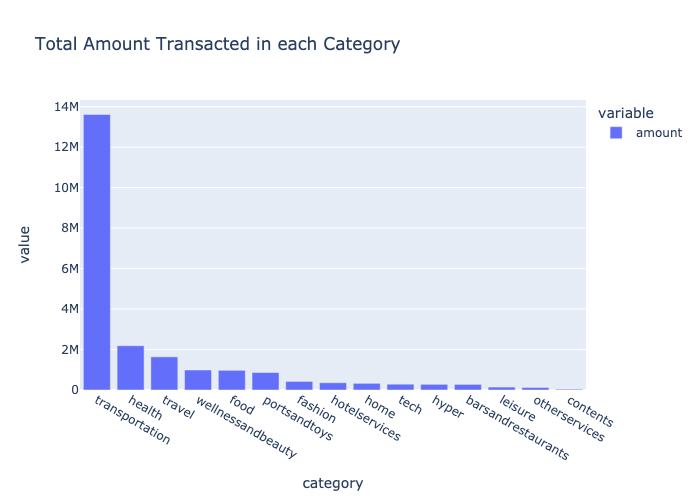

In [46]:
total_category = df.groupby('category')['amount'].sum().sort_values(ascending = False)
fig = px.bar(total_category, title ='Total Amount Transacted in each Category')
fig.show('png')

We can see that transportation leads the way with almost 14 million transacted

### Let's see the total amount transacted by each age group

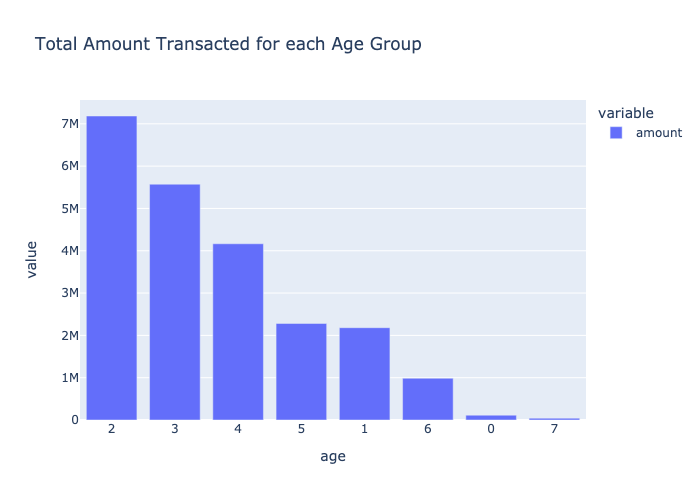

In [47]:
total_age = df.groupby('age')['amount'].sum().sort_values(ascending = False)
fig = px.bar(total_age, title='Total Amount Transacted for each Age Group')
fig.show('png')

We can see that age group '2' has the highest amount transacted out of all age groups. This makes sense because we already established earlier that they had the highest percentages of fraud and non-fraud cases 

### Now let's look at gender 

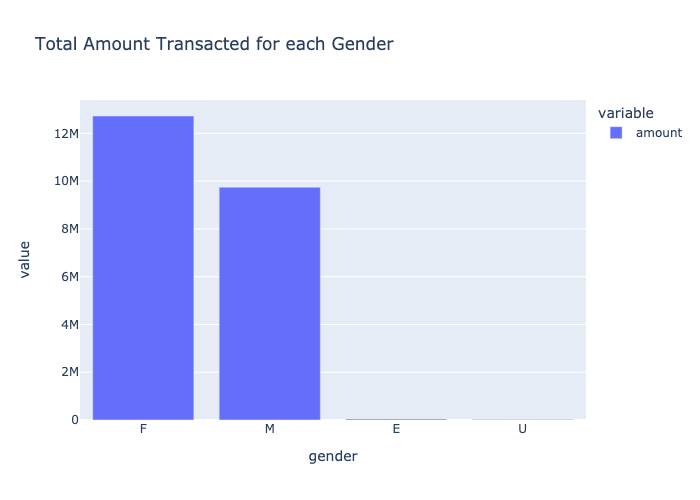

In [45]:
Total_gender = df.groupby('gender')['amount'].sum().sort_values(ascending = False)
fig = px.bar(Total_gender, title = 'Total Amount Transacted for each Gender')
fig.show('png')

Again, the female gender has the highest amount transacted 

### Let's separate the fraud cases from the non-fraud cases to examine the data further 

In [30]:
fraud_df = df[df['fraud']==1]
nofraud_df = df[df['fraud']==0]
fraud_df.shape, nofraud_df.shape

((7200, 7), (587443, 7))

In [31]:
fraud_df['customer'].value_counts()

C1350963410    144
C1849046345    127
C806399525     125
C2004941826    119
C1275518867    114
              ... 
C1059874896      1
C1828909550      1
C1514271157      1
C1386324281      1
C1239184141      1
Name: customer, Length: 1483, dtype: int64

We can see that there are 1483 customers responsible for the 7200 fraud cases present in the dataset. 

### Let's visualize the top 20 customers with the highest number of fraud cases

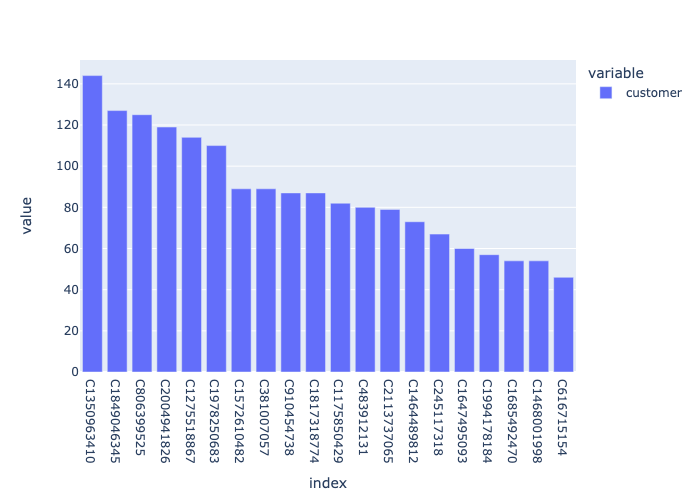

In [32]:
fraud_customers = fraud_df['customer'].value_counts().head(20)
fig = px.bar(fraud_customers)
fig.show("png")

### Now let's check the fraud distribution between merchants

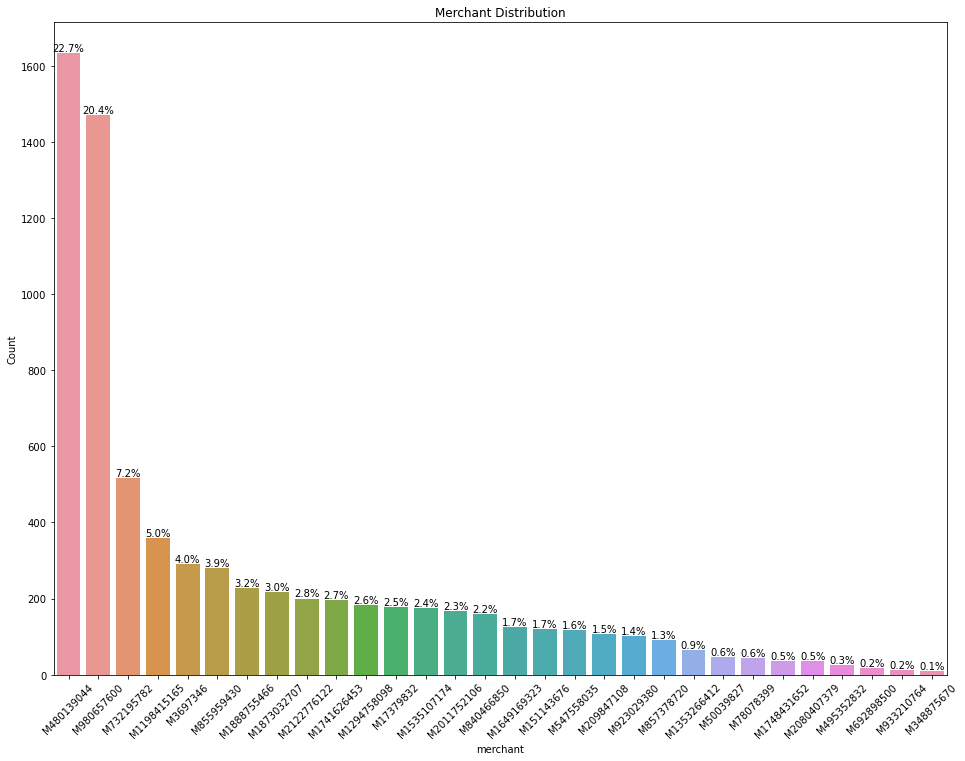

In [33]:
plt.figure(figsize=(16,12))
ax = sns.countplot(x="merchant", data=fraud_df, order = fraud_df['merchant'].value_counts().index)
ax.set(ylabel='Count', title='Merchant Distribution')


# add annotations
for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/fraud_df.fraud.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')
plt.xticks(rotation = 45)

plt.show()

We can see that both merchant 'M480139044' and merchant 'M980657600' have the bulk of fraud cases totaling 43.1%. Let's explore both merchants further by identifying the categories in which the frauds are taking place and the total amounts transacted for each merchant

In [34]:
top_fraud_merchant1 = fraud_df[fraud_df['merchant'] == 'M480139044'][['category', 'amount']]
print(f"Category1: {top_fraud_merchant1['category'].unique()}, Total amount transacted: {top_fraud_merchant1['amount'].sum()}")
top_fraud_merchant2 = fraud_df[fraud_df['merchant'] == 'M980657600'][['category', 'amount']]
print(f"Category2: {top_fraud_merchant2['category'].unique()}, Total amount transacted: {top_fraud_merchant2['amount'].sum()}")

Category1: ['health'], Total amount transacted: 664804.3899999999
Category2: ['portsandtoys'], Total amount transacted: 505311.62


We can see that for merchant 'M480139044', the fraudulent activities happen in the health category with the total amount transacted being 664,804 while for merchant 'M980657600', the fradulent activities happen in the sports and toys category with the total amount transacted being 505,311

### Let's check the total fraudulent amount transacted in each category

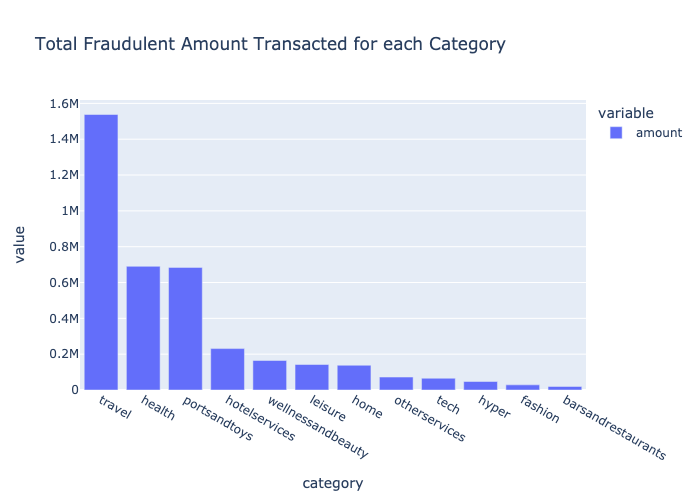

In [44]:
category_amount = fraud_df.groupby('category')['amount'].sum().sort_values(ascending = False)
fig = px.bar(category_amount, title= 'Total Fraudulent Amount Transacted for each Category')
fig.show("png")

We can see that the most fraudulent transactions happen in the travel category. What merchants were affected by this ?

In [36]:
fraud_df[fraud_df['category'] == 'travel']['merchant'].unique()

array(['M495352832', 'M732195782', 'M2080407379'], dtype=object)

Merchants 'M495352832', 'M732195782' and 'M2080407379' were all affected by fraudulent activities in the travel category. What amounts were transacted ? 

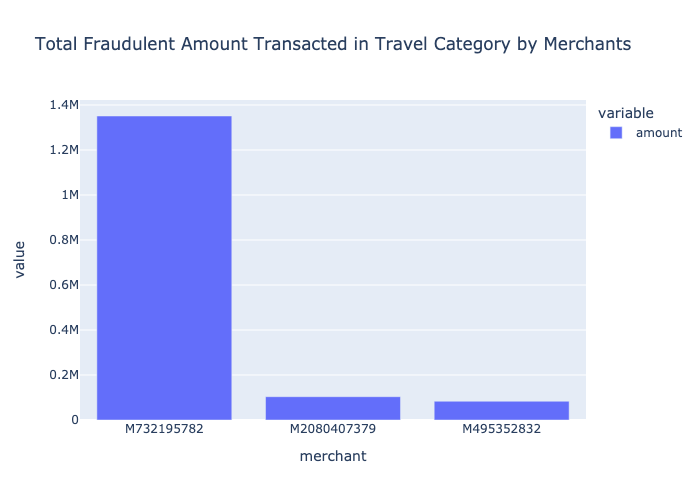

In [48]:
total_merchant = fraud_df[fraud_df['category'] == 'travel'][['merchant','amount']].groupby('merchant')['amount'].sum().sort_values(ascending = False)
fig = px.bar(total_merchant, title='Total Fraudulent Amount Transacted in Travel Category by Merchants')
fig.show('png')

We can see that merchant 'M732195782' accounted for majority of the fraud transactions in the travel category with a total amount of almost 1,400,000

### Converting Categorical Variables to Numerical Variables

In order to perform machine learning techniques on the data, we first need to convert categorical variables into numerical form. There are various ways to do this but i decided to go with the Count/Frequency enconding technique. This technique replaces the categorocal variables by the amount times they appear in the dataset

In [30]:
categorical_variables = ['customer','merchant','gender','category']

In [31]:
encoder_dictionary = {}
for var in categorical_variables:
    encoder_dictionary[var]= (df[var].value_counts()/len(df)).to_dict()

In [32]:
for var in categorical_variables:
    df[var] = df[var].map(encoder_dictionary[var])

In [33]:
df.head()

,customer,age,gender,merchant,category,amount,fraud
0,0.000281,4,0.451338,0.345461,0.849449,4.55,0
1,0.000284,2,0.451338,0.345461,0.849449,39.68,0
2,0.000109,4,0.545815,0.503988,0.849449,26.89,0
3,0.000288,3,0.451338,0.345461,0.849449,17.25,0
4,0.000244,5,0.451338,0.345461,0.849449,35.72,0


We can see now that all variables are now numeric 

### Feature Selection

Let's define X and y

In [34]:
X = df.iloc[:,0:6]
X

,customer,age,gender,merchant,category,amount
0,0.000281,4,0.451338,0.345461,0.849449,4.55
1,0.000284,2,0.451338,0.345461,0.849449,39.68
2,0.000109,4,0.545815,0.503988,0.849449,26.89
3,0.000288,3,0.451338,0.345461,0.849449,17.25
4,0.000244,5,0.451338,0.345461,0.849449,35.72
...,...,...,...,...,...,...
594638,0.000309,3,0.545815,0.503988,0.849449,20.53
594639,0.000289,4,0.545815,0.503988,0.849449,50.73
594640,0.000283,2,0.545815,0.004845,0.010854,22.44
594641,0.000277,5,0.451338,0.503988,0.849449,14.46


In [35]:
y = df.iloc[:,6]
y

0         0
1         0
2         0
3         0
4         0
         ..
594638    0
594639    0
594640    0
594641    0
594642    0
Name: fraud, Length: 594643, dtype: int64

### Normalizing Data 

In [36]:
X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)
X

,customer,age,gender,merchant,category,amount
0,0.340420,0.737975,-0.930770,-0.182271,0.420912,-0.299276
1,0.410385,-0.759162,-0.930770,-0.182271,0.420912,0.016067
2,-3.227803,0.737975,0.817933,0.765246,0.420912,-0.098742
3,0.480350,-0.010593,-0.930770,-0.182271,0.420912,-0.185275
4,-0.429197,1.486544,-0.930770,-0.182271,0.420912,-0.019480
...,...,...,...,...,...,...
594638,0.935123,-0.010593,0.817933,0.765246,0.420912,-0.155832
594639,0.515333,0.737975,0.817933,0.765246,0.420912,0.115256
594640,0.375402,-0.759162,0.817933,-2.218135,-2.422660,-0.138687
594641,0.270455,1.486544,-0.930770,0.765246,0.420912,-0.210319


### Train/Test Split

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2, random_state =42)

### Resampling

Earlier we highlighted that the dataset was highly imblanced. This poses a huge problem for us because if a model was to be created with the imbalanced dataset, the model performance will be affected significantly. Therefore, there's a need to resample the dataset. There's a number of techniques we can use for resampling a dataset but the most common one is called SMOTE. SMOTE is an oversampling technique where synthetic samples are generated for the minority class. In our case, the minority class is the fraud cases. 

In [39]:
smote = SMOTE(random_state=42)

In [40]:
X_res, Y_res = smote.fit_resample(X_train,Y_train) #fitting only the training set to smote
print('original:', Counter(Y_train))
print('resampled:', Counter(Y_res))

original: Counter({0: 469931, 1: 5783})
resampled: Counter({0: 469931, 1: 469931})


We can see that the number our fraud cases are now equal to the number of non-fraud cases 

### Model Training

We will first define a function that will perform a grid search for the optimal hyperparameters of the classifier. The cross-validation strategy for each model uses 3 folds in a stratified KFold. The metric the models in the search are evaluated on is the Area Under the Receiver Operating Characteristic Curve (ROC AUC). The function prints the parameters that yield the highest AUC score and returns the parameters of the best estimator as its output

In [41]:
def xgboost_search(X, y, search_verbose=1):
    params = {
    "gamma":[0.5, 1, 1.5, 2, 5],
    "max_depth":[3,4,5,6],
    "min_child_weight": [100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)

    grid_search.fit(X, y)

    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

Because of the large nature of the training set, we will limit the grid search to a sample of 5000 observations

In [42]:
rows = random.sample(np.arange(0,len(X_res.index)).tolist(), 5000)
model_params = xgboost_search(X_res.iloc[rows,], Y_res.iloc[rows,])

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=100,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Parameters:  {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 100, 'subsample': 0.8}
Highest AUC: 0.99


Now that we have the optimal parameters, we can now train the model

In [43]:
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)
model.fit(X_res, Y_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=100,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Model Evaluation

In order to properly evaluate how the model performs on the test data, i used an evaluation metric called ROC-AUC. ROC stands for Receiver Operator Charasteristic and it is a probability curve that plots the TPR(True positive rate) against FPR(False positive rate) at various threshold values. The Area Under the Curve(AUC) will be used to measure the ability of the classifier to distinguish between classes. The higher the AUC, the better the model performs. 

Let's plot the curve

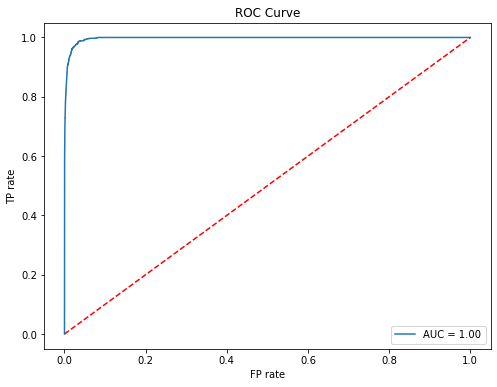

In [44]:
y_pred = model.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(Y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

Because we are dealing with fraud detection, the cost of one misclassification is significantly higher than the other. This means that if a legitimate transaction is misclassified, the worst case scenario is inconvenience whereas if a fraudulent transaction is misclassified, there are far worse consequences. Therefore, we have to select a threshold that reduces the false negatives at the expense of the false positives. 
Looking the the ROC curve above, we would want to select a threshold at the top left corner (i.e True postive rate is high and False positive rate is low). There are a number of ways to select the optimal threshold, for this project, i have chosen the Youden's J statistic method. 

In [45]:
t_opt_idx = np.argmax(tp_r - fp_r)
t_opt = t[t_opt_idx]
print("Threshold value is: %.2f" % t_opt)

Threshold value is: 0.20


We can see that the optimal threshold is given as 0.20. Let's visualize this on the curve

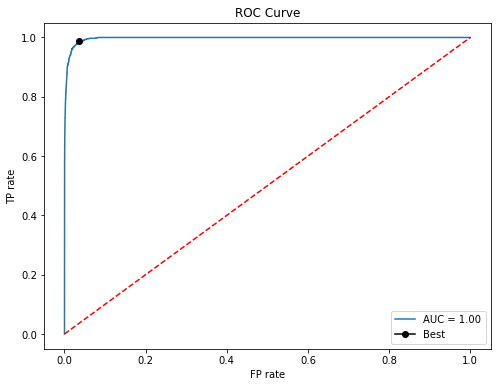

In [46]:
fp_r, tp_r, t = metrics.roc_curve(Y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.plot(fp_r[t_opt_idx], tp_r[t_opt_idx], marker='o', color='black',label='Best')
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

We can clearly see that the optimal threshold is located at the top-left corner which is indeed what we wanted. 

We can also manually inspect the confusion matrices at different threshold levels

Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

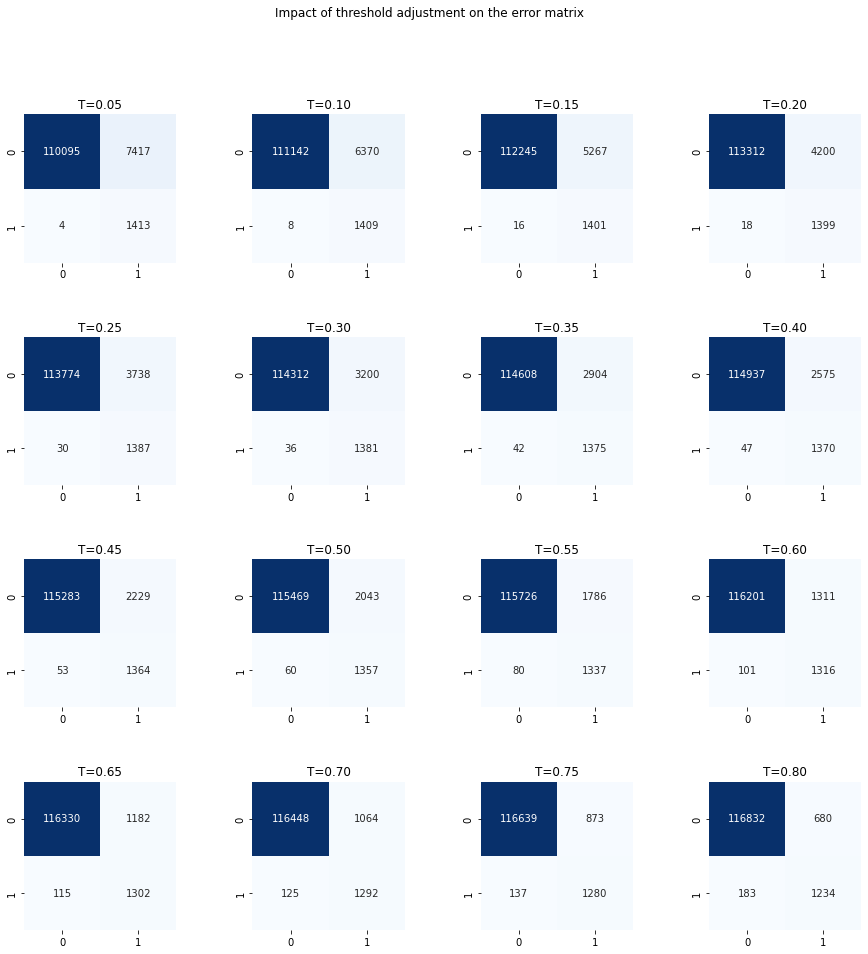

In [47]:
y_pred = model.predict_proba(X_test)[:,1]

fig, axes = plt.subplots(4,4, figsize=(15,15))

for t, ax in enumerate(axes.flat):
    threshold = (t+1)/20

    y_pred_int = (y_pred > threshold).astype(int)
    c_matrix = metrics.confusion_matrix(Y_test, y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.2f" % threshold)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the confusion matrix")

Looking at the confusion matrices above, we can see that T=0.20 gives the best interpretation as it is clearly prioritising a lower false negative rate over a lower false postive rate. If we decide to increase the threshold, we can see that more fraudulent cases will be missed and if we decide to reduce the threshold, the false positives significantly increases. Therefore, i am satisfied with this balance. 

In [48]:
# saving the model
filename = 'finalized_model.sav' 
pickle.dump(model, open(filename, 'wb'))

## THANK YOU FOR VIEWING MY NOTEBOOK